## A post-VAD Speaker Counter

In [5]:
# region init

import os
import random


import pandas as pd
import numpy as np


import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader


from time import time
from tqdm import tqdm


from src import model as m  # Config


from src.data import SpectrogramDataset   # Torch dataset object creator


import random
import numpy as np
import torch


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# endregion





# region Helpers
# Data loaders for full data set
def get_loaders(dataset, train_frac=0.8, bs=32, seed=42):
    n = len(dataset)
    t = int(train_frac * n)
    train_ds, val_ds = random_split(dataset, [t, n-t], generator=torch.Generator().manual_seed(seed))
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(val_ds, batch_size=bs, shuffle=False))



# Data loaders for subset, makes hp tuning quicker (stratified sampling prevents class imbalance)
def get_stratified_loaders(
    dataset,
    subset_frac: float = 0.3,
    train_frac: float = 0.8,
    batch_size: int = 32,
    random_state: int = 42,
    shuffle_train: bool = True
):

    # 1. Stratified sampling of the full dataset
    full_indices = list(range(len(dataset)))
    labels = dataset.labels
    subset_idx, _ = train_test_split(
        full_indices,
        train_size=subset_frac,
        stratify=labels,
        random_state=random_state
    )
    reduced_ds = Subset(dataset, subset_idx)

    # 2. Stratified train/val split of the reduced dataset
    reduced_labels = [labels[i] for i in subset_idx]
    train_idx, val_idx = train_test_split(
        list(range(len(reduced_ds))),
        train_size=train_frac,
        stratify=reduced_labels,
        random_state=random_state
    )

    # 3. Build DataLoaders
    train_loader = DataLoader(
        Subset(reduced_ds, train_idx),
        batch_size=batch_size,
        shuffle=shuffle_train
    )
    val_loader = DataLoader(
        Subset(reduced_ds, val_idx),
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader



# Model builder
def build_model(cfg, input_h, input_w):
    return m.ConvVAD(
        input_height=input_h, input_width=input_w,
        conv1_out=cfg['conv1_out'], conv2_out=cfg['conv2_out'], fc_hidden=cfg['fc_hidden'],
        dropout_prob=cfg['dropout_prob']
    )



# One‐epoch training with tqdm
def train_one_epoch(model, loader, opt, crit, device):
    model.train()
    total_loss = 0.0

    for x, y in tqdm(loader, desc="Training", unit="batch"):
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        logits = model(x)  # shape: [batch_size, 2]
        loss = crit(logits, y).mean()  # shape: []

        loss.backward()
        opt.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    return avg_loss



# Evaluate model
def validate(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
    return correct / len(loader.dataset)
# endregion

In [2]:
# Changed classes to 0 or 1 - Whether a voice is present or not
_df = pd.read_csv(r"data\labels\final_labels.csv")
_df['class'] = _df['speaker_count'].apply(lambda x: 1 if x != '0' else 0); _df

df_speech = _df[_df['class'] == 1]
df_silence = _df[_df['class'] == 0]

print(f"1's: {len(df_speech)} \n 0's: {len(df_silence)}")

1's: 104560 
 0's: 11719


In [10]:
# Downsampling the 1 class as it will overwhelm the 0 class
from sklearn.utils import resample

df_speech_downsampled = resample(
    df_speech,
    replace=False,
    n_samples=50000,
    random_state=42
)

# Combine and shuffle
df_VAD = pd.concat([df_speech_downsampled, df_silence]).sample(frac=1, random_state=42)

df_VAD.to_csv(r"data\labels\final_labels_VAD.csv", index=False) 
dataset = SpectrogramDataset(csv_file=r"data\labels\final_labels_VAD.csv"); 

In [ ]:
# 1. init ConvCount model
model = build_model(m.config_VAD, input_h=64, input_w=101)



# 2. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



# 3. DataLoaders
# get_stratified_loaders() is preferred in testing to create a fair subset
# get_loaders() gets the entire training set - high compute, only for final model

train_loader, val_loader = get_stratified_loaders(
    dataset, subset_frac=0.1, train_frac=0.8, batch_size=32, random_state=42
)

# train_loader, val_loader = get_loaders(dataset)

for x, y in train_loader:
    print(f"Actual batch shape: {x.shape}")
    break


# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=m.config['lr'])



# 5. Training loop
for epoch in range(10):
    start_time = time()
    avg_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    duration = time() - start_time
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f} — Time: {duration:.2f}s")


# 6. Final Validation 
acc = validate(model, val_loader, device)
print(f"Validation Accuracy: {acc:.2%}")


# 7. Save model
torch.save(model.state_dict(), r'src/model/ConvVAD.pt')

Actual batch shape: torch.Size([32, 1, 64, 101])


Training: 100%|██████████| 155/155 [00:19<00:00,  7.85batch/s]


Epoch 1 — Loss: 0.1755 — Time: 19.75s


Training: 100%|██████████| 155/155 [00:35<00:00,  4.32batch/s]


Epoch 2 — Loss: 0.0298 — Time: 35.84s


Training: 100%|██████████| 155/155 [00:57<00:00,  2.71batch/s]


Epoch 3 — Loss: 0.0231 — Time: 57.19s


Training: 100%|██████████| 155/155 [01:05<00:00,  2.36batch/s]


Epoch 4 — Loss: 0.0183 — Time: 65.60s


Training: 100%|██████████| 155/155 [00:36<00:00,  4.28batch/s]


Epoch 5 — Loss: 0.0149 — Time: 36.20s
Validation Accuracy: 99.43%


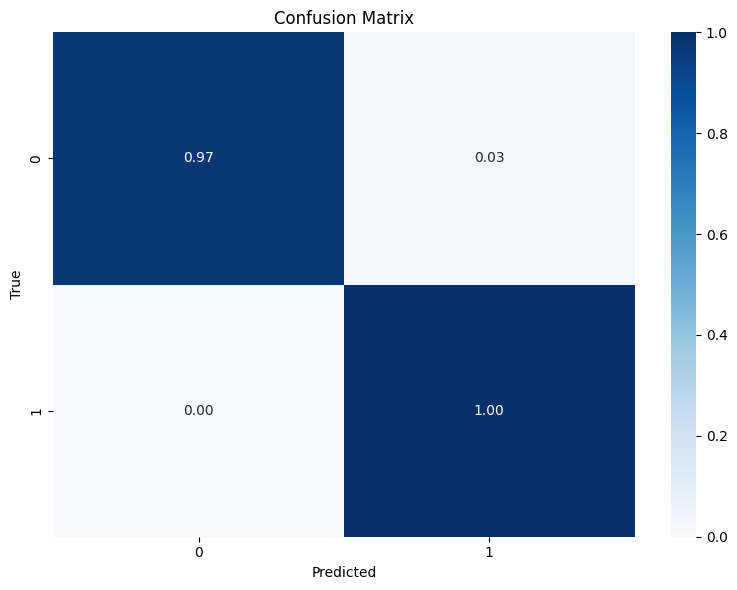


Per-Class Accuracy:
  Class 0: 0.970
  Class 1: 1.000

Precision / Recall / F1 Score per Class:
  Class 0: Precision=1.000, Recall=0.970, F1=0.985
  Class 1: Precision=0.993, Recall=1.000, F1=0.997


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

def evaluate_classification(y_true, y_pred, class_labels=None, normalize_cm=False):
    """
    Computes and visualizes confusion matrix, per-class accuracy, and precision/recall/F1.

    Args:
        y_true (array-like): Ground truth labels (integers).
        y_pred (array-like): Predicted labels (integers).
        class_labels (list[int], optional): List of integer class labels (e.g., [0,1,2,3,4]).
            If None, it's inferred from y_true and y_pred.
        normalize_cm (bool): Whether to normalize confusion matrix rows.

    Returns:
        dict: Dictionary containing metrics and the confusion matrix.
    """
    metrics = {}

    # Infer class labels if not provided
    if class_labels is None:
        unique = set(np.unique(y_true)).union(np.unique(y_pred))
        class_labels = sorted(int(x) for x in unique)

        # If predictions/targets don't include all expected classes (e.g., want 0..4),
        # a caller can pass class_labels explicitly. We keep inference conservative.

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    if normalize_cm:
        # avoid divide-by-zero rows
        with np.errstate(all='ignore'):
            cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)  # convert NaNs to 0 for empty rows

    metrics['confusion_matrix'] = cm
    metrics['class_labels'] = class_labels

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize_cm else "d",
                xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Per-Class Accuracy
    per_class_acc = {}
    for cls in class_labels:
        cls_mask = np.array(y_true) == cls
        if cls_mask.sum() == 0:
            per_class_acc[cls] = None
        else:
            acc = accuracy_score(np.array(y_true)[cls_mask], np.array(y_pred)[cls_mask])
            per_class_acc[cls] = acc
    metrics['per_class_accuracy'] = per_class_acc

    print("\nPer-Class Accuracy:")
    for cls in class_labels:
        acc = per_class_acc[cls]
        if acc is None:
            print(f"  Class {cls}: (no true samples)")
        else:
            print(f"  Class {cls}: {acc:.3f}")

    # Precision, Recall, F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=class_labels, zero_division=0
    )
    metrics['precision'] = dict(zip(class_labels, precision))
    metrics['recall'] = dict(zip(class_labels, recall))
    metrics['f1_score'] = dict(zip(class_labels, f1))

    print("\nPrecision / Recall / F1 Score per Class:")
    for cls in class_labels:
        print(f"  Class {cls}: Precision={metrics['precision'][cls]:.3f}, "
              f"Recall={metrics['recall'][cls]:.3f}, F1={metrics['f1_score'][cls]:.3f}")

    return metrics


def evaluate_model_metrics(model, loader, device, class_labels=None):
    """
    Run model on loader and evaluate. class_labels is optional (list of ints).
    If class_labels is None it will be inferred from the data (y_true/y_pred).
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy())

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)

    # If user passed class_labels, use that; otherwise infer a sensible range
    if class_labels is None:
        unique = set(np.unique(y_true)).union(np.unique(y_pred))
        class_labels = sorted(int(x) for x in unique)
        
    return evaluate_classification(y_true, y_pred, class_labels=class_labels, normalize_cm=True)


# Usage example (simple):
metrics = evaluate_model_metrics(model, val_loader, device)
# or to force classes 0..4:
# metrics = evaluate_model_metrics(model, val_loader, device, class_labels=[0,1,2,3,4])


### This looks great! It does appear to be overfitting; but this doesn't matter as long as the model works in prod too.